In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import NMF
from sklearn.metrics import confusion_matrix, SCORERS
from sklearn.utils.multiclass import unique_labels

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import chi2_contingency


pd.set_option('display.max_columns', None, 'display.max_rows', None)

In [2]:
imagepath = Path('../images')
datapath = Path('../data')
full = 'cleaned_full_1.csv'
survey = 'features_not_scaled.csv'
std_feats = 'high_std_feats.csv'
W_mat = 'w_matrix_7_topics.csv'

In [8]:
full_df = pd.read_csv(datapath/full)
df = pd.read_csv(datapath/survey)
W_df = pd.read_csv(datapath/W_mat)

In [82]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     print(cm)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.matshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [80]:
def rf_predict(df, full_df, n_topics, prefix='swb'):
    keep = [c for c in df.columns if prefix not in c]
    X = MinMaxScaler().fit_transform(df[keep])  

    nmf = NMF(n_components=n_topics, random_state=0,
              alpha=.3, l1_ratio=.5).fit(X)

    W = nmf.transform(X)
    
    target = prefix + '_target'
    y = full_df[target]

    model = RandomForestClassifier(n_estimators=100)
    score = cross_val_score(model, W, y, cv=5, scoring='f1_weighted', n_jobs=-1)
    score = np.mean(score)
    print(f'f1_weighted: {score}')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    ax = plot_confusion_matrix(y_test, preds)
    
    return confusion_matrix(y_test, preds)


f1_weighted: 0.6385583102669159


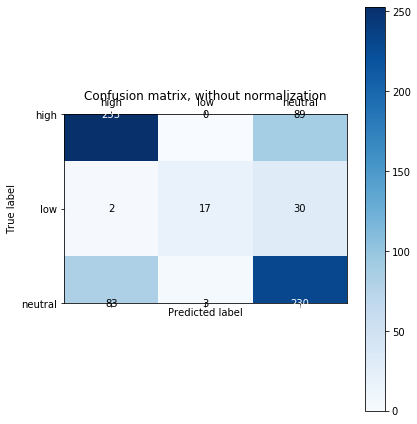

In [81]:
cm = rf_predict(df, full_df, 7, prefix='swb');

# Chi Square

In [114]:
# Run nmf to get W
prefix='swb'
n_topics=7

keep = [c for c in df.columns if prefix not in c]

X = MinMaxScaler().fit_transform(df[keep])  

nmf = NMF(n_components=n_topics, random_state=0,
          alpha=.3, l1_ratio=.5).fit(X)

W = nmf.transform(X)

# Get heirarcical clusters/labels from W
X = MinMaxScaler().fit_transform(W_df)
Z = linkage(X, method='ward')
labels = fcluster(Z, t=8, criterion='distance')

In [127]:
# Number of clusters
u_labels, count = np.unique(labels, return_counts=True)

In [175]:
# Make df boolean based on labels
# Get counts for each cluster

swb_df = pd.DataFrame()

for label in u_labels:
    cond = (labels == label)
    s = full_df.loc[cond,:]['swb_target'].value_counts().sort_index()
    swb_df = swb_df.append(s, ignore_index=True)
swb_df.insert(0, 'cluster', u_labels)


In [185]:
# Compare C1 to others
def chi2_to_df(df, u_labels):
    for label in u_labels:
        to_col = []
        Cx = df[df.cluster==label].iloc[:,1:4].values
        
        for c in u_labels:
            Cy = df[df.cluster==c].iloc[:,1:4].values
            chi2, p, ddof, expected = chi2_contingency([Cx,Cy])
            to_col.append(round(p, 2))
        
        df[f'vs {label}'] = to_col
            
    return df

In [187]:
swb_df = chi2_to_df(swb_df, u_labels)

In [188]:
swb_df

,cluster,high,low,neutral,vs 1,vs 2,vs 3,vs 4,vs 5,vs 6
0,1,56.0,156.0,276.0,1.0,0.00,0.00,0.00,0.00,0.00
1,2,154.0,6.0,130.0,0.0,1.00,0.80,0.83,0.57,0.52
2,3,219.0,12.0,186.0,0.0,0.80,1.00,0.91,0.85,0.77
3,4,201.0,10.0,161.0,0.0,0.83,0.91,1.00,0.88,0.87
4,5,296.0,18.0,237.0,0.0,0.57,0.85,0.88,1.00,0.98
5,6,384.0,23.0,301.0,0.0,0.52,0.77,0.87,0.98,1.00
